In [1]:
import unittest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utility import *
from tools import *
from maps import *
from measure_properties import *

In [2]:

""" Unit testing.
    The following code tests the functionality of various classes and methods
    and prints the results ('ok' if they match PhotoZ expected outputs, 
                                FAIL or ERROR if they don't).
"""
test_zda_1 = 'test_data/01_02_03.zda'
test_roi_1 = 'test_data/1_rois.dat'
test_traces_1 = 'test_data/Traces1.dat'

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

test_traces_1_data = read_dat_trace_file(test_traces_1)

# Parameters Setting.
startPt = 96
numPt = 50
basePt = 96
skipPt = 30
tools = Tools()
maps = Maps()

# Load and preprocess the Data.
'''
From PhotoZ: The order is data inversing, RLI dividing, temporal filtering,
amplitude correcting, spatial filtering, baseline correction
	dataInversing();
	rliDividing();
	temporalFiltering();
	...
	sp->spatialFilter();
	sp->baseLineCorrection();
'''
data_no_rli_div = DataLoader(test_zda_1,
                             number_of_points_discarded=0).get_data(rli_division=False) # Trials * height * width * timepoints.
data_no_rli_div = tools.T_filter(Data=data_no_rli_div)
data_no_rli_div = tools.S_filter(sigma=1, Data=data_no_rli_div)
data_no_rli_div = tools.Polynomial(startPt=basePt, numPt=skipPt, Data=data_no_rli_div)

#rois = ROIFileReader(test_roi_1).get_roi_list()

trace1 = TraceSelector(data_no_rli_div).get_trace_from_roi([[56,25]])  # Get trace from first ROI.
trace2 = TraceSelector(data_no_rli_div).get_trace_from_roi([[43,33]])  # Get trace from second ROI.


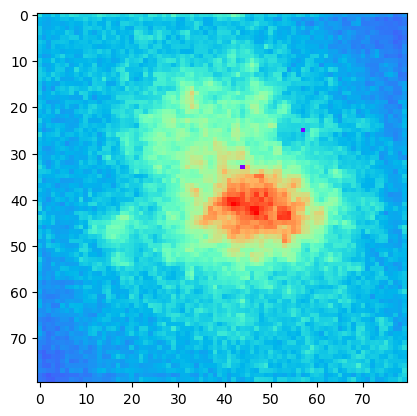

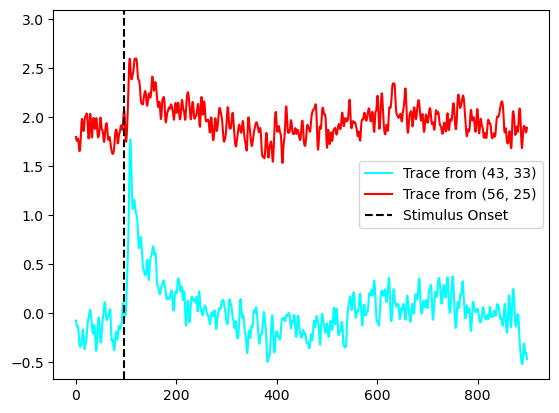

columns in test_traces_1_data: Index(['Pt', 'D2057', 'D2684'], dtype='object')


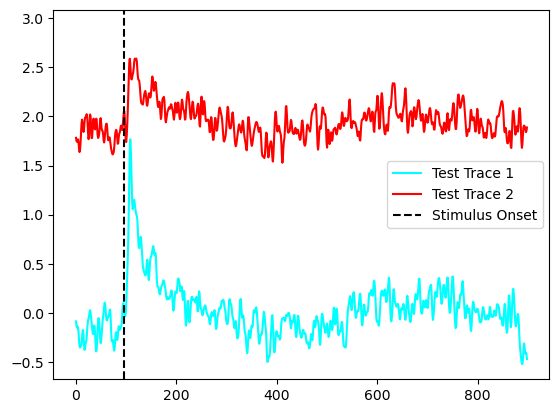

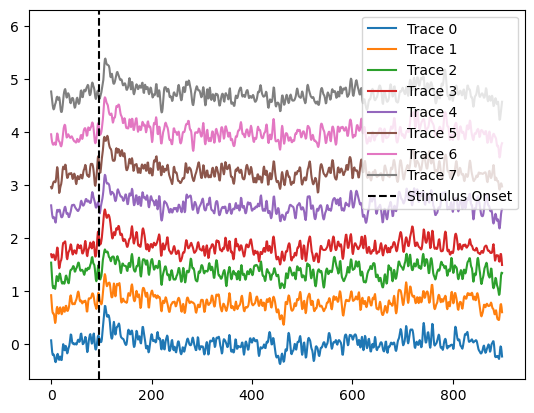

Found matching trace to test_traces_1_data['D2057'] at pixel (56, 25)


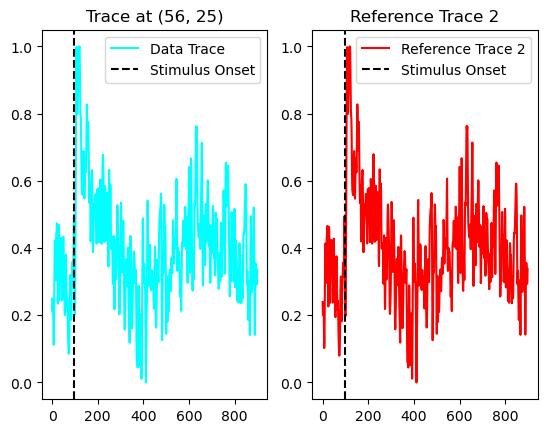

Found matching trace to test_traces_1_data['D2684'] at pixel (43, 33)


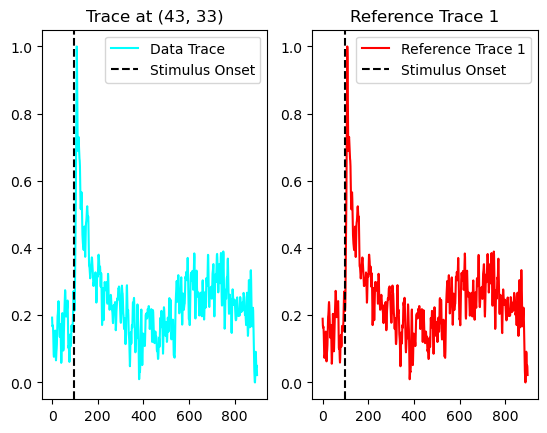

In [3]:
stim_time = 96

arr = np.max(data_no_rli_div, axis=(0,3))
# blank out [57, 25] and [44, 33] to mark their locations
arr[25,57] = 0
arr[33,44] = 0
plt.imshow(arr, cmap='rainbow')
plt.show()

# show the traces at those locations
plt.plot(trace2, label='Trace from (43, 33)', c='cyan')
plt.plot(trace1 + np.max(trace2) * 1.1, label='Trace from (56, 25)', c='red')
# raise ylim 10%
ylims = plt.gca().get_ylim()
plt.ylim(ylims[0], ylims[1] + (ylims[1]-ylims[0]) * 0.1)
#mark stim time with vertical line
plt.axvline(x=stim_time, color='k', linestyle='--', label='Stimulus Onset')
plt.legend()
plt.show()
print("columns in test_traces_1_data:", test_traces_1_data.columns)
# compare to test_traces_1_data
plt.plot(test_traces_1_data['D2684'], label='Test Trace 1', c='cyan')
plt.plot(test_traces_1_data['D2057'] + np.max(test_traces_1_data['D2684']) * 1.1, label='Test Trace 2', c='red')
# raise ylim 10%
ylims = plt.gca().get_ylim()
plt.ylim(ylims[0], ylims[1] + (ylims[1]-ylims[0]) * 0.1)
plt.axvline(x=stim_time, color='k', linestyle='--', label='Stimulus Onset')
plt.legend()
plt.show()

# show neighboring traces around ((25, 57)) 
neighbor_px = [[24,56], [24,57], [24,58],
                [25,56],          [25,58],
                [26,56], [26,57], [26,58]]  # Get trace from first ROI.
baseline = 0
for i, px in enumerate(neighbor_px):
    trace = TraceSelector(data_no_rli_div).get_trace_from_roi([px])
    plt.plot(trace + baseline, label=f'Trace {i}')
    baseline += np.max(trace) * 1.1
# raise ylim 10%
ylims = plt.gca().get_ylim()
plt.ylim(ylims[0], ylims[1] + (ylims[1]-ylims[0]) * 0.1)
plt.axvline(x=stim_time, color='k', linestyle='--', label='Stimulus Onset')
plt.legend()
plt.show()

# look through all pixels and see if their trace is very close to trace1 or trace2
# plot them side by side if so
tolerance = 1e-2
height = data_no_rli_div.shape[1]
width = data_no_rli_div.shape[2]
for y in range(height):
    for x in range(width):
        trace = TraceSelector(data_no_rli_div).get_trace_from_roi([[x,y]])
        # normalize both traces to their own min and max for comparison
        trace = (trace - np.min(trace)) / (np.max(trace) - np.min(trace))
        test_trace_1_norm = (test_traces_1_data['D2684'] - np.min(test_traces_1_data['D2684'])) / (np.max(test_traces_1_data['D2684']) - np.min(test_traces_1_data['D2684']))
        test_trace_2_norm = (test_traces_1_data['D2057'] - np.min(test_traces_1_data['D2057'])) / (np.max(test_traces_1_data['D2057']) - np.min(test_traces_1_data['D2057']))
        if np.allclose(trace, test_trace_1_norm, atol=tolerance):
            print(f"Found matching trace to test_traces_1_data['D2684'] at pixel ({x}, {y})")
            plt.subplot(1,2,1)
            plt.title(f"Trace at ({x}, {y})")
            plt.plot(trace, label='Data Trace', c='cyan')
            plt.axvline(x=stim_time, color='k', linestyle='--', label='Stimulus Onset')
            plt.legend()
            plt.subplot(1,2,2)
            plt.title("Reference Trace 1")
            plt.plot(test_trace_1_norm, label='Reference Trace 1', c='red')
            plt.axvline(x=stim_time, color='k', linestyle='--', label='Stimulus Onset')
            plt.legend()
            plt.show()
        elif np.allclose(trace, test_trace_2_norm, atol=tolerance):
            print(f"Found matching trace to test_traces_1_data['D2057'] at pixel ({x}, {y})")
            plt.subplot(1,2,1)
            plt.title(f"Trace at ({x}, {y})")
            plt.plot(trace, label='Data Trace', c='cyan')
            plt.axvline(x=stim_time, color='k', linestyle='--', label='Stimulus Onset')
            plt.legend()
            plt.subplot(1,2,2)
            plt.title("Reference Trace 2")
            plt.plot(test_trace_2_norm, label='Reference Trace 2', c='red')
            plt.axvline(x=stim_time, color='k', linestyle='--', label='Stimulus Onset')
            plt.legend()
            plt.show()

In [4]:

test_zda_2 = 'test_data/07_01_02.zda'
test_roi_2 = 'test_data/07_01_ROIs_1_to_100.dat'
test_max_amp_2 = 'test_data/07_01_max_amp.dat'
test_latency_2 = 'test_data/07_01_latency.dat'
test_halfwidth_2 = 'test_data/07_01_halfwidth.dat'
test_snr_2 = 'test_data/07_01_snr.dat'
test_max_amp_latency_2 = 'test_data/07_01_max_amp_latency.dat'
test_traces_file_2 = 'test_data/Traces7.dat'

# Parameters Setting.
startPt = 96
numPt = 50
basePt = 96
skipPt = 30
tools = Tools()
maps = Maps()

# Load and preprocess the Data.
'''
From PhotoZ: The order is data inversing, RLI dividing, temporal filtering,
amplitude correcting, spatial filtering, baseline correction
	dataInversing();
	rliDividing();
	temporalFiltering();
	...
	sp->spatialFilter();
	sp->baseLineCorrection();
'''
dl_no_div_2 = DataLoader(test_zda_2,
							 number_of_points_discarded=0)
data_no_rli_div_2 = dl_no_div_2.get_data(rli_division=False) # Trials * height * width * timepoints.
data_no_rli_div_2 = tools.T_filter(Data=data_no_rli_div_2)
data_no_rli_div_2 = tools.S_filter(sigma=1, Data=data_no_rli_div_2)
data_no_rli_div_2 = tools.Polynomial(startPt=basePt, numPt=skipPt, Data=data_no_rli_div_2)

fp_data = dl_no_div_2.get_fp()

rois_2 = ROIFileReader(test_roi_2).get_roi_list()

trace1 = TraceSelector(data_no_rli_div).get_trace_from_roi([[56,25]])  # Get trace from first ROI.
trace2 = TraceSelector(data_no_rli_div).get_trace_from_roi([[43,33]])  # Get trace from second ROI.

traces_2 = []
for roi in rois_2:
    traces_2.append(TraceSelector(data_no_rli_div_2).get_trace_from_roi(roi))  # Get traces from all ROIs.

traces_expected_2 = read_dat_trace_file(test_traces_file_2)
max_amp_expected_2 = pd.read_csv(test_max_amp_2, sep='\t', header=None).to_numpy()[:, 1]
latency_expected_2 = pd.read_csv(test_latency_2, sep='\t', header=None).to_numpy()[:, 1]
halfwidth_expected_2 = pd.read_csv(test_halfwidth_2, sep='\t', header=None).to_numpy()[:, 1]
snr_expected_2 = pd.read_csv(test_snr_2, sep='\t', header=None).to_numpy()[:, 1]
max_amp_latency_expected_2 = pd.read_csv(test_max_amp_latency_2, sep='\t', header=None).to_numpy()[:, 1]

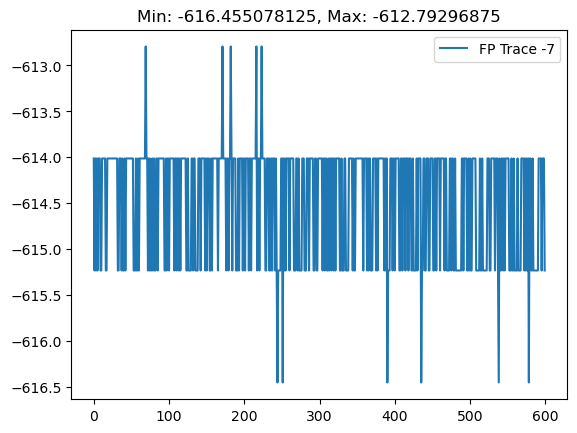

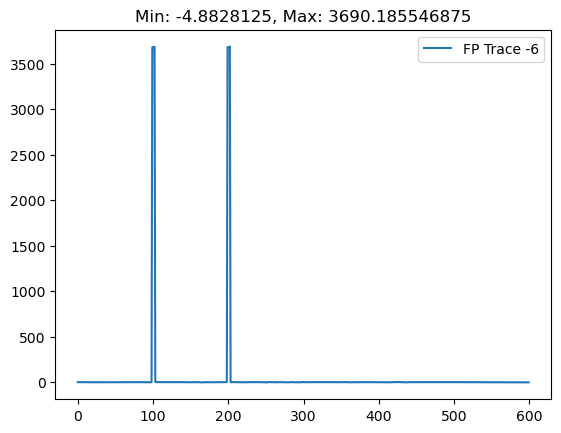

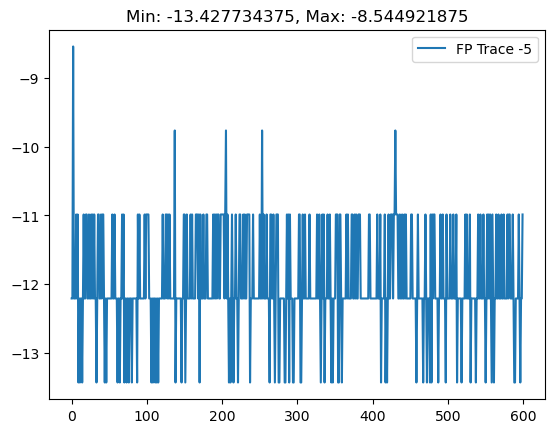

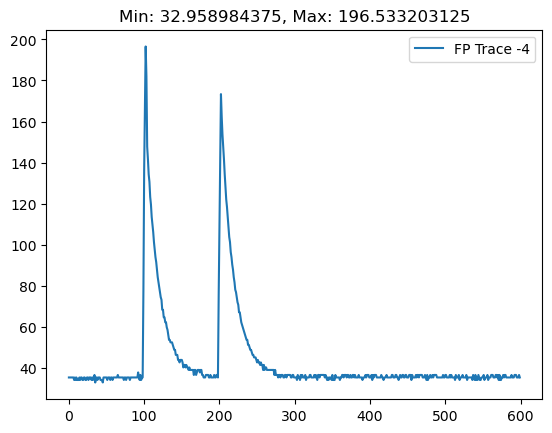

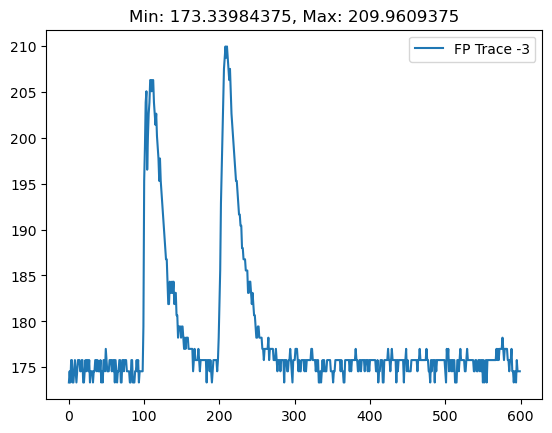

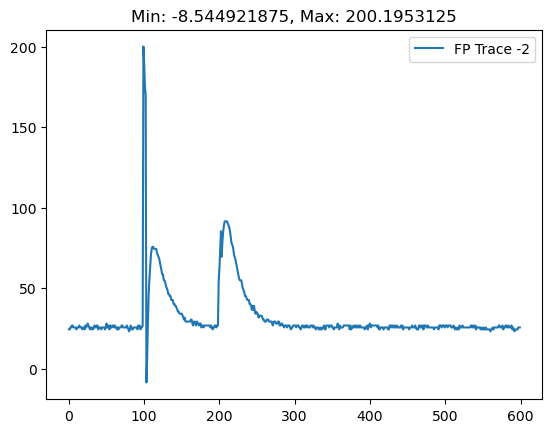

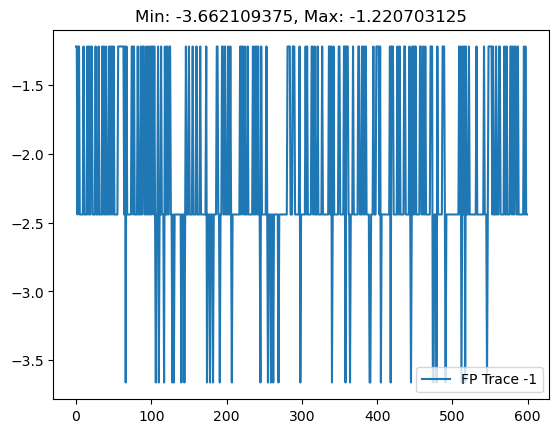

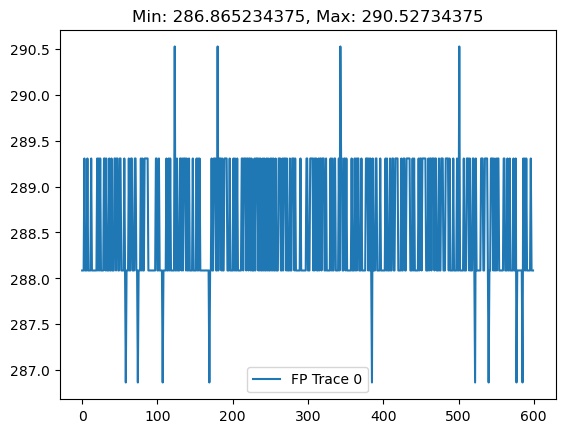

In [5]:
# plot fp data traces
for i in range(8):
    trace = fp_data[i, :]
    plt.plot(trace, label=f'FP Trace {i-7}')
    #plt.ylim(19995, 20010)
    plt.title("Min: " + str(np.min(trace)) + ", Max: " + str(np.max(trace)))
    #plt.xlim(0, 10)
    plt.legend()
    plt.show()

No matching trace found for expected trace 15 in traces_2


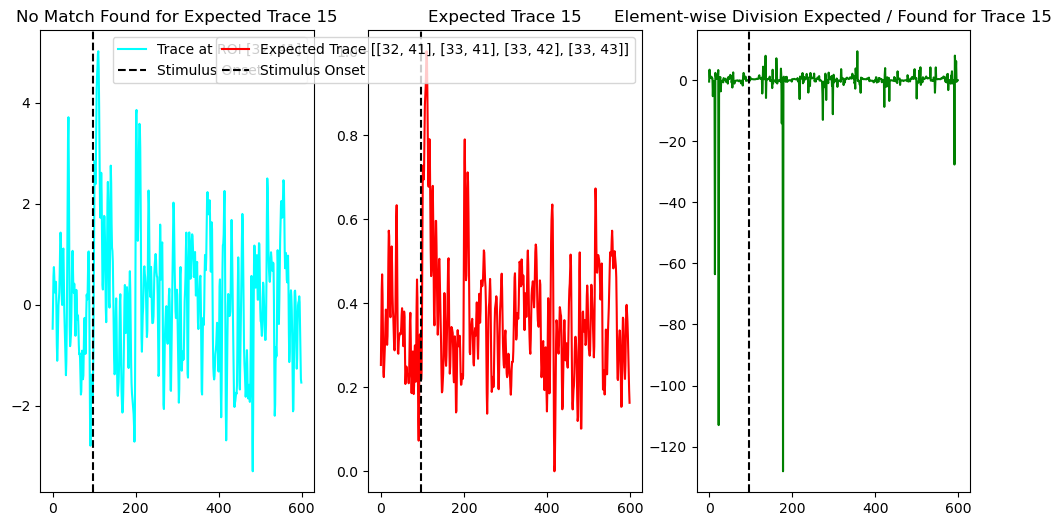

Found matching trace for expected trace 16 in traces_2 at pixel (11, 44)


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_16200\4198367488.py:44: RuntimeWarning: invalid value encountered in true_divide
  division = expected_trace / trace


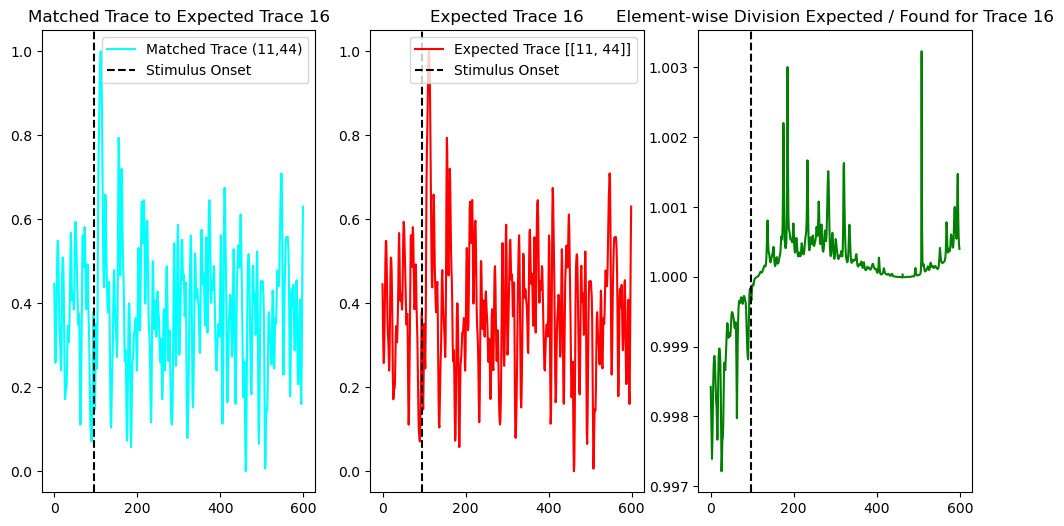

No matching trace found for expected trace 17 in traces_2


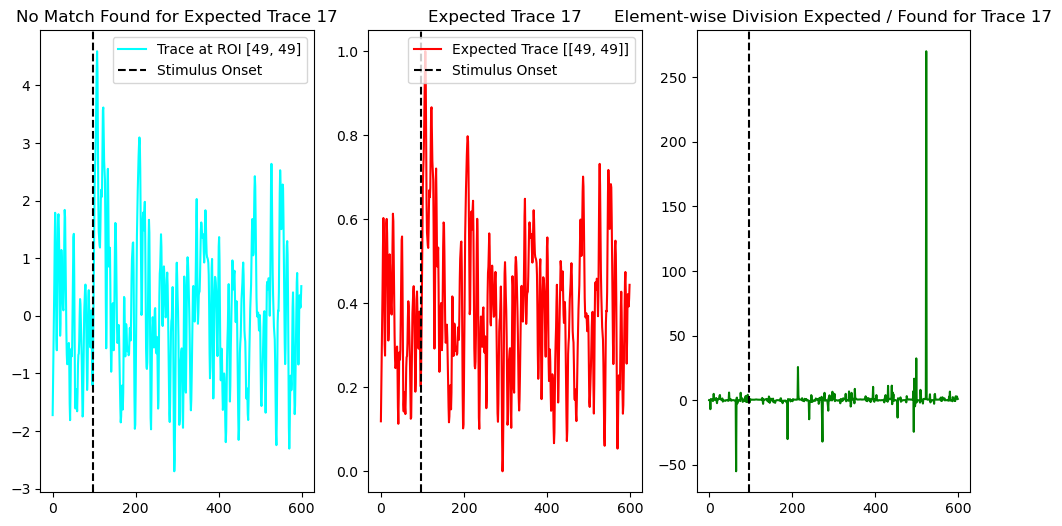

No matching trace found for expected trace 18 in traces_2


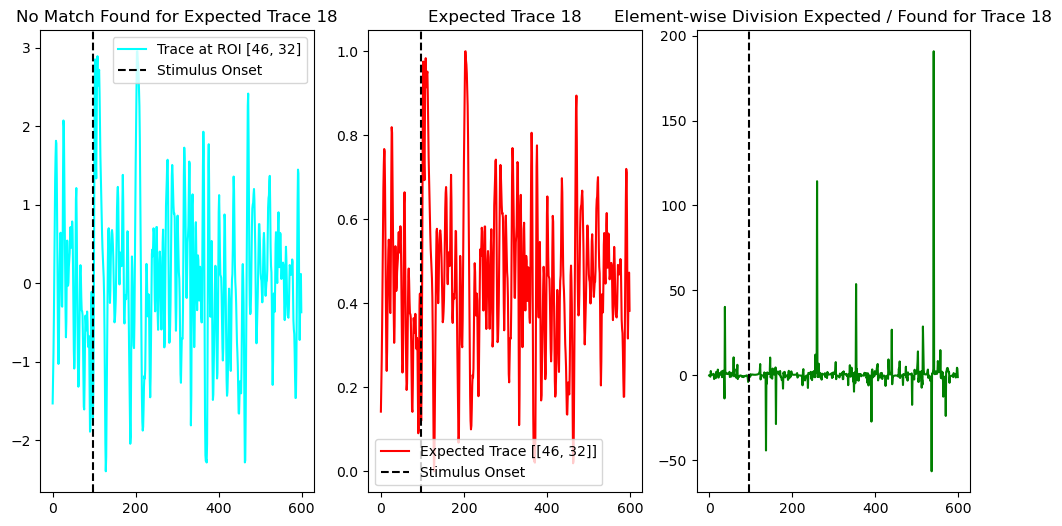

No matching trace found for expected trace 19 in traces_2


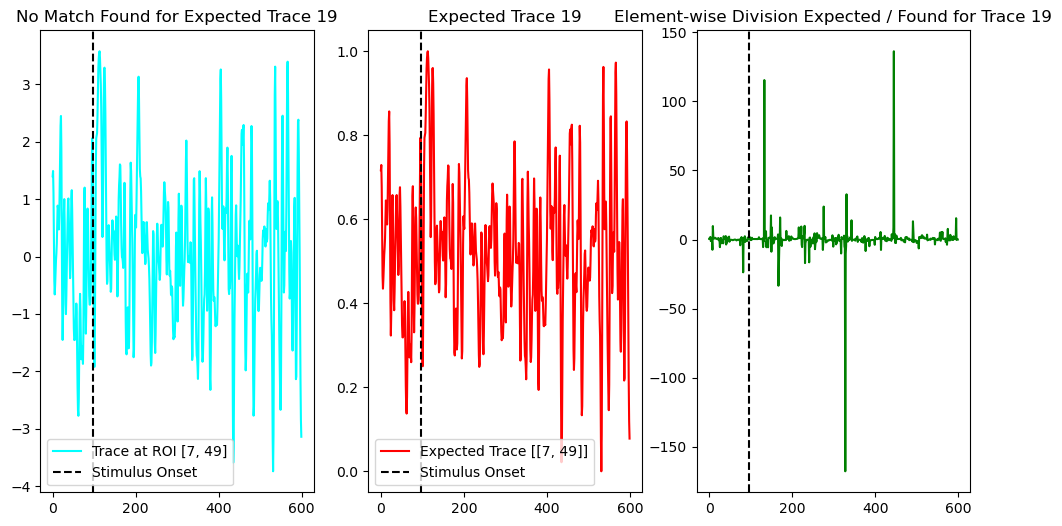

No matching trace found for expected trace 20 in traces_2


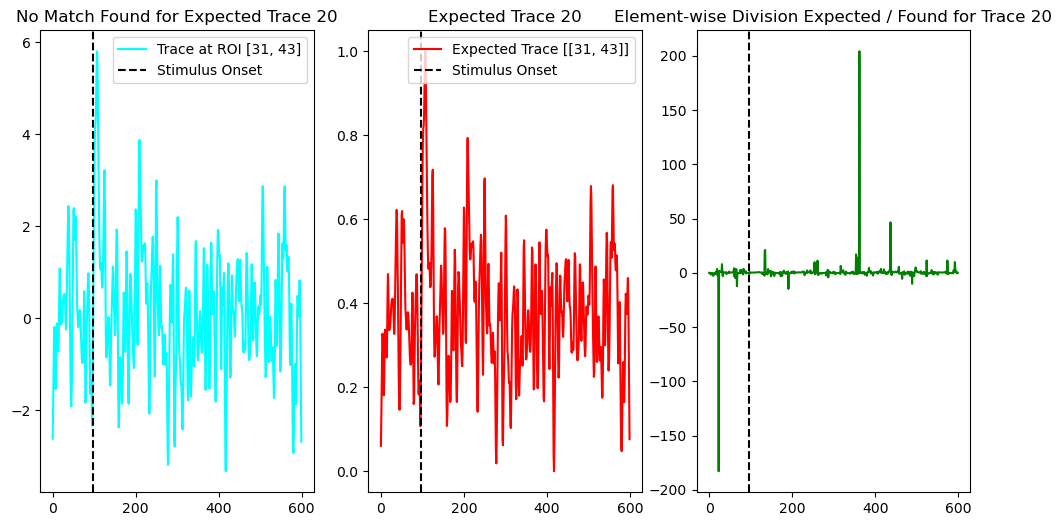

Found matching trace for expected trace 21 in traces_2 at pixel (42, 37)


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_16200\4198367488.py:44: RuntimeWarning: invalid value encountered in true_divide
  division = expected_trace / trace


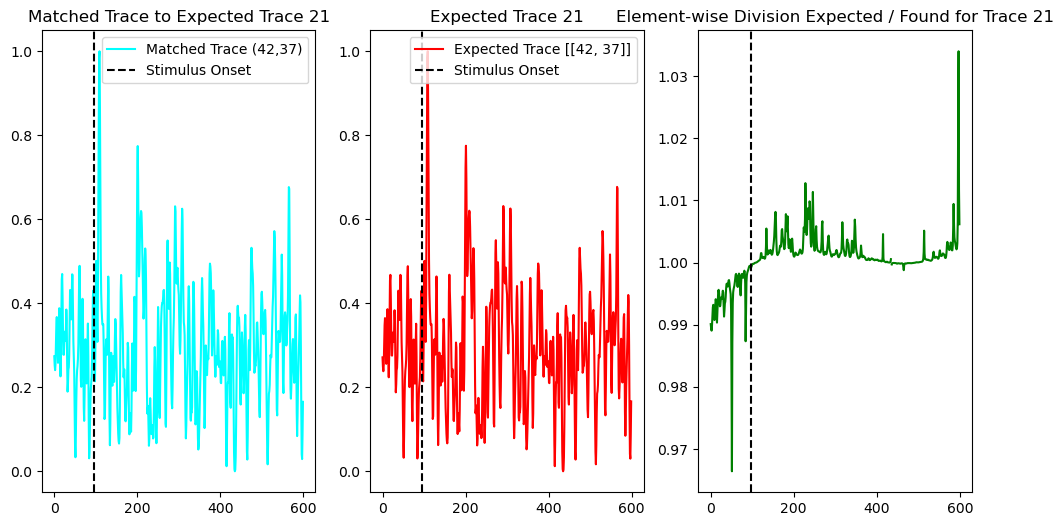

Found matching trace for expected trace 22 in traces_2 at pixel (6, 71)


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_16200\4198367488.py:44: RuntimeWarning: invalid value encountered in true_divide
  division = expected_trace / trace


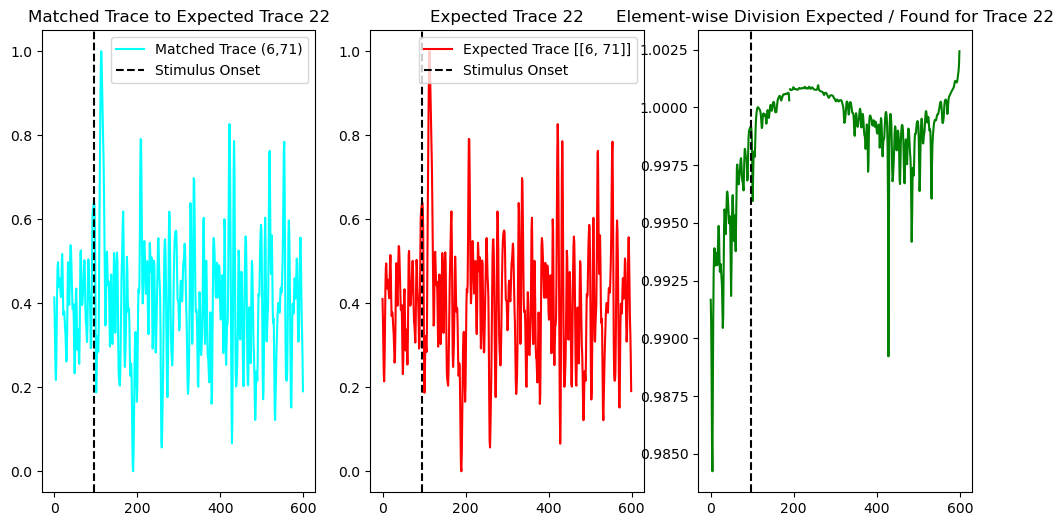

No matching trace found for expected trace 23 in traces_2


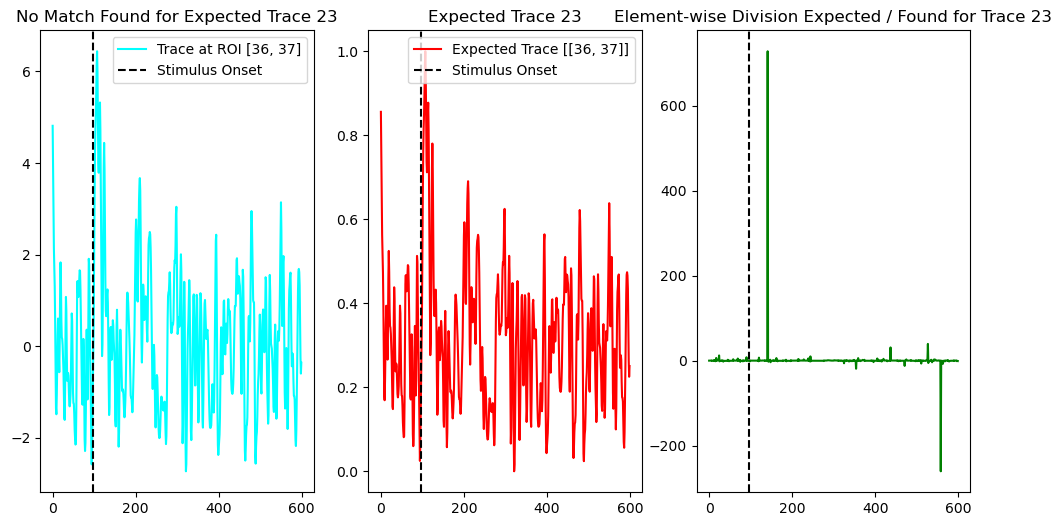

No matching trace found for expected trace 24 in traces_2


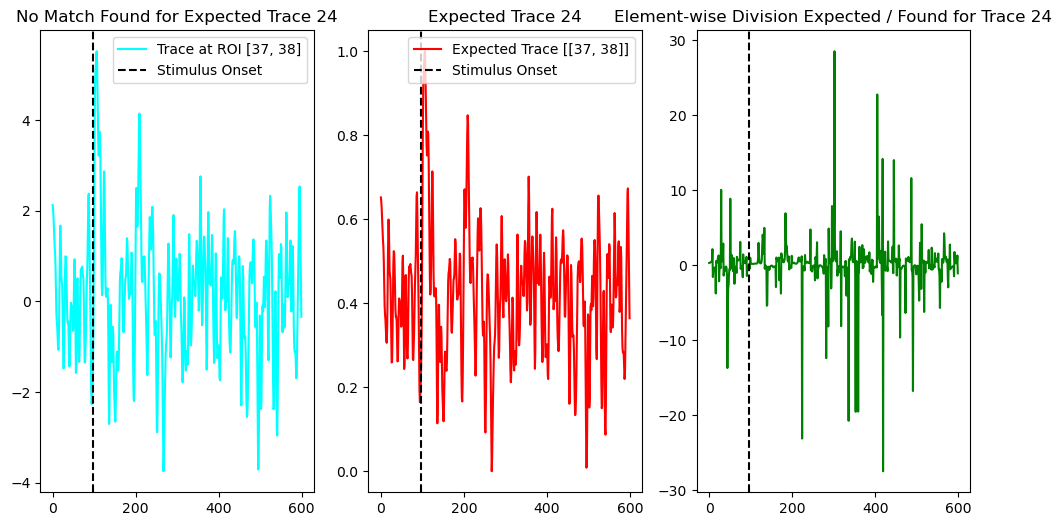

Found matching trace for expected trace 25 in traces_2 at pixel (5, 42)


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_16200\4198367488.py:44: RuntimeWarning: invalid value encountered in true_divide
  division = expected_trace / trace


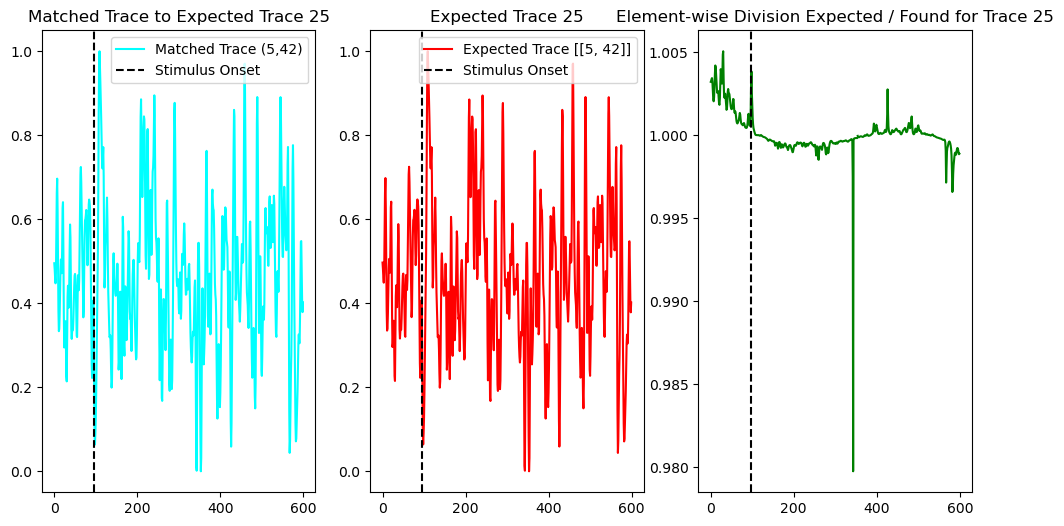

No matching trace found for expected trace 26 in traces_2


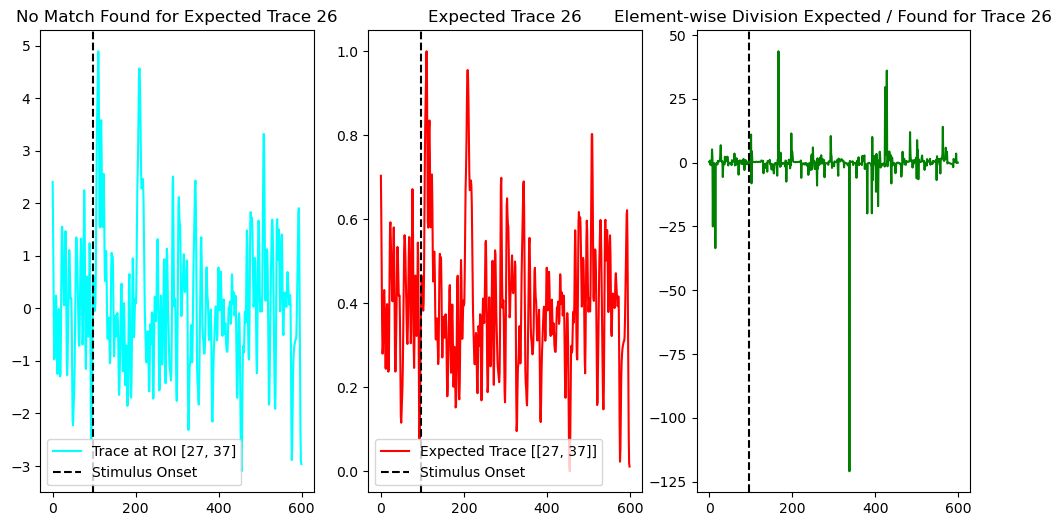

In [6]:
# for each expected trace, search for a close match in traces_2
for i in range(15, len(traces_expected_2.columns)):
    expected_trace = traces_expected_2.iloc[:, i].to_numpy()
    # normalize expected trace to its own min and max for comparison
    expected_trace = (expected_trace - np.min(expected_trace)) / (np.max(expected_trace) - np.min(expected_trace))
    found_match = False
    for x in range(80):
        for y in range(80):
            trace = TraceSelector(data_no_rli_div_2).get_trace_from_roi([[x,y]])
            # normalize trace to its own min and max for comparison
            trace = (trace - np.min(trace)) / (np.max(trace) - np.min(trace))
            if np.allclose(trace, expected_trace, atol=1e-2):
                print(f"Found matching trace for expected trace {i} in traces_2 at pixel ({x}, {y})")
                found_match = True
                break
        if found_match:
            break
        
    if not found_match:
        print(f"No matching trace found for expected trace {i} in traces_2")
    # show match, and show expected vs found x,y location
    # adjust plot size
    plt.figure(figsize=(12, 6))
    plt.subplot(1,3,1)
    if found_match:
        plt.title(f"Matched Trace to Expected Trace {i}")
        plt.plot(trace, label=f'Matched Trace ({x},{y})', c='cyan')
    else:  # plot equivalent pixel's trace
        plt.title(f"No Match Found for Expected Trace {i}")
        x_roi, y_roi = rois_2[i-1][0]
        trace = TraceSelector(data_no_rli_div_2).get_trace_from_roi([[x_roi,y_roi]])
        plt.plot(trace, label=f'Trace at ROI {rois_2[i-1][0]}', c='cyan')
    plt.axvline(x=stim_time, color='k', linestyle='--', label='Stimulus Onset')
    plt.legend()
    plt.subplot(1,3,2)
    plt.title(f"Expected Trace {i}")
    plt.plot(expected_trace, label=f'Expected Trace {rois_2[i-1]}', c='red')
    plt.axvline(x=stim_time, color='k', linestyle='--', label='Stimulus Onset')
    plt.legend()
    plt.subplot(1,3,3)
    # show element wise division of expected_trace / trace
    plt.title(f"Element-wise Division Expected / Found for Trace {i}")
    
    division = expected_trace / trace
    plt.plot(division, label='Expected / Matched', c='green')
    plt.axvline(x=stim_time, color='k', linestyle='--', label='Stimulus Onset')

    plt.show()

    if i > 25:  # limit output for brevity
        break

In [7]:
# Test the MeasureProperties class to validate against
# values extracted via PhotoZ.

decimal_precision = 2  # number of decimal places to check
delta_precision = 0.02
snr_delta_precision = 0.05
percent_conform_require = 0.95  # For bulk testing, 95% of values must conform within delta_precision

class TestMeasureProperties2(unittest.TestCase):
    def test_length_traces_no_rli_division(self):
        n_tests_passed = 0
        for i, trace in enumerate(traces_2):
            length = len(trace)
            len_expected = len(traces_expected_2['ROI' + str(i+1)])
            if length == len_expected:
                n_tests_passed += 1
        self.assertGreaterEqual(n_tests_passed / len(traces_2), percent_conform_require,
                            msg=f"Number of tests passed, {n_tests_passed} of {len(traces_2)}, for length of traces " +
                            " without RLI division does not meet required percentage {}.".format(percent_conform_require))
    
    def test_max_amp_no_rli_division(self):
        n_tests_passed = 0
        for i, trace in enumerate(traces_2):
            max_amp = TraceProperties(trace, startPt, numPt, 0.5).get_max_amp()
            max_amp_expected = max_amp_expected_2[i]
            if np.abs(max_amp - max_amp_expected) < delta_precision:
                n_tests_passed += 1
        self.assertGreaterEqual(n_tests_passed / len(traces_2), percent_conform_require,
                            msg=f"Number of tests passed, {n_tests_passed} of {len(traces_2)}, for max amplitude of traces " +
                            " without RLI division does not meet required percentage {}.".format(percent_conform_require))

    def test_latency_no_rli_division(self):
        n_tests_passed = 0
        for i, trace in enumerate(traces_2):
            latency = TraceProperties(trace, startPt, numPt, 0.5).get_half_amp_latency()
            latency_expected = latency_expected_2[i]
            if np.abs(latency - latency_expected) < delta_precision:
                n_tests_passed += 1
        self.assertGreaterEqual(n_tests_passed / len(traces_2), percent_conform_require,
                            msg=f"Number of tests passed, {n_tests_passed} of {len(traces_2)}, for latency of traces " +
                            " without RLI division does not meet required percentage {}.".format(percent_conform_require))

    def test_max_amp_latency_no_rli_division(self):
        n_tests_passed = 0
        for i, trace in enumerate(traces_2):
            max_amp_latency = TraceProperties(trace, startPt, numPt, 0.5).get_max_amp_latency()
            max_amp_latency_expected = max_amp_latency_expected_2[i]
            if np.abs(max_amp_latency - max_amp_latency_expected) < delta_precision:
                n_tests_passed += 1
        self.assertGreaterEqual(n_tests_passed / len(traces_2), percent_conform_require,
                            msg=f"Number of tests passed, {n_tests_passed} of {len(traces_2)}, for max amplitude latency of traces " +
                            " without RLI division does not meet required percentage {}.".format(percent_conform_require))
        
    def test_half_width_no_rli_division(self):
        n_tests_passed = 0
        for i, trace in enumerate(traces_2):
            half_width = TraceProperties(trace, startPt, numPt, 0.5).get_half_width()
            half_width_expected = halfwidth_expected_2[i]
            if np.abs(half_width - half_width_expected) < delta_precision:
                n_tests_passed += 1
        self.assertGreaterEqual(n_tests_passed / len(traces_2), percent_conform_require,
                            msg=f"Number of tests passed, {n_tests_passed} of {len(traces_2)}, for half width of traces " +
                            " without RLI division does not meet required percentage {}.".format(percent_conform_require))

class TestROIFileReader(unittest.TestCase):

    def test_roi_diode_num_converter(self):
        diode_num1 = 2057
        diode_num2 = 2684
        x_px1, y_px1 = ROIFileReader(None).diode_num_to_points([diode_num1])[0]
        x_px2, y_px2 = ROIFileReader(None).diode_num_to_points([diode_num2])[0]
        self.assertEqual((x_px1, y_px1), (57, 25),
                         msg="Diode number 2057 did not convert to expected "
                         "(x,y) coordinates.")
        self.assertEqual((x_px2, y_px2), (44, 33),
                         msg="Diode number 2684 did not convert to expected "
                         "(x,y) coordinates.")
        
class TestMeasureProperties1(unittest.TestCase):

    # assertAlmostEqual(first, second, places=7, msg=None, delta=None)

    def test_length_traces_no_rli_division(self):
        length1 = len(trace1)
        len_expected1 = len(test_traces_1_data['D2057'])
        self.assertEqual(length1, len_expected1,
                         msg="Length of trace 1 without RLI division, " + str(length1) + \
                         ", does not match expected value.")
        length2 = len(trace2)
        len_expected2 = len(test_traces_1_data['D2684'])
        self.assertEqual(length2, len_expected2,
                         msg="Length of trace 2 without RLI division, " + str(length2) + \
                         ", does not match expected value.")

    def test_max_amp_no_rli_division(self):
        max_amp1 = TraceProperties(trace1, startPt, numPt, 0.5).get_max_amp()
        self.assertAlmostEqual(max_amp1, 0.645248, delta=delta_precision,
                               msg="Max amplitude for trace 1 without RLI division does not match expected value.")
        max_amp2 = TraceProperties(trace2, startPt, numPt, 0.5).get_max_amp()
        self.assertAlmostEqual(max_amp2, 1.76777, delta=delta_precision,
                               msg="Max amplitude for trace 2 without RLI division does not match expected value.")

    def test_half_width_no_rli_division(self):
        half_width1 = TraceProperties(trace1, startPt, numPt, 0.5).get_half_width()
        self.assertAlmostEqual(half_width1, 12.0453, delta=delta_precision,
                               msg="Half width for trace 1 without RLI division does not match expected value.")
        half_width2 = TraceProperties(trace2, startPt, numPt, 0.5).get_half_width()
        self.assertAlmostEqual(half_width2, 9.35652, delta=delta_precision,
                               msg="Half width for trace 2 without RLI division does not match expected value.")
        
    def test_latency_no_rli_division(self):
        latency1 = TraceProperties(trace1, startPt, numPt, 0.5).get_half_amp_latency()
        self.assertAlmostEqual(latency1, 52.1217, delta=delta_precision,
                               msg="Latency for trace 1 without RLI division does not match expected value.")
        latency2 = TraceProperties(trace2, startPt, numPt, 0.5).get_half_amp_latency()
        self.assertAlmostEqual(latency2, 52.2692, delta=delta_precision,
                               msg="Latency for trace 2 without RLI division does not match expected value.")

    def test_snr_no_rli_division(self):
        snr1 = TraceProperties(trace1, startPt, numPt, 0.5).get_SNR()
        self.assertAlmostEqual(snr1, 8.10524, delta=snr_delta_precision, # increased delta due to larger values
                               msg="SNR for trace 1 without RLI division does not match expected value.")
        snr2 = TraceProperties(trace2, startPt, numPt, 0.5).get_SNR()
        self.assertAlmostEqual(snr2, 13.2091, delta=snr_delta_precision,  # increased delta due to larger values
                               msg="SNR for trace 2 without RLI division does not match expected value.")

    def test_max_amp_latency_no_rli_division(self):
        max_amp_latency1 = TraceProperties(trace1, startPt, numPt, 0.5).get_max_amp_latency()
        self.assertAlmostEqual(max_amp_latency1, 60, delta=delta_precision,
                               msg="Max amplitude latency for trace 1 without RLI division does not match expected value.")
        max_amp_latency2 = TraceProperties(trace2, startPt, numPt, 0.5).get_max_amp_latency()
        self.assertAlmostEqual(max_amp_latency2, 54, delta=delta_precision,
                               msg="Max amplitude latency for trace 2 without RLI division does not match expected value.")

if __name__ == '__main__':
    runner = unittest.main(argv=[''], exit=False, verbosity=1)

....

........
----------------------------------------------------------------------
Ran 12 tests in 0.045s

OK


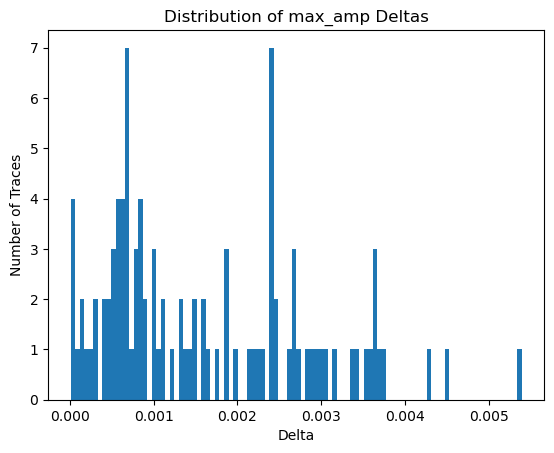

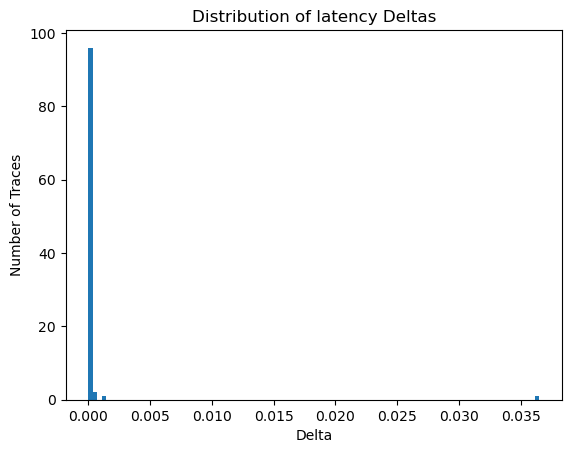

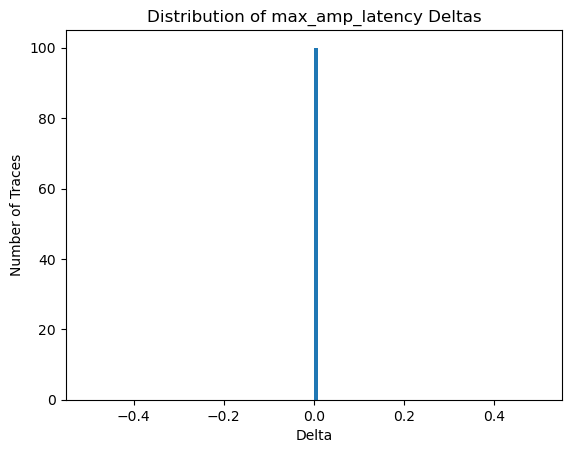

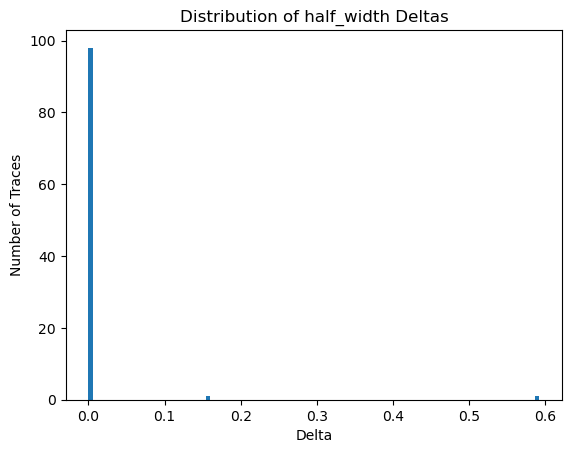

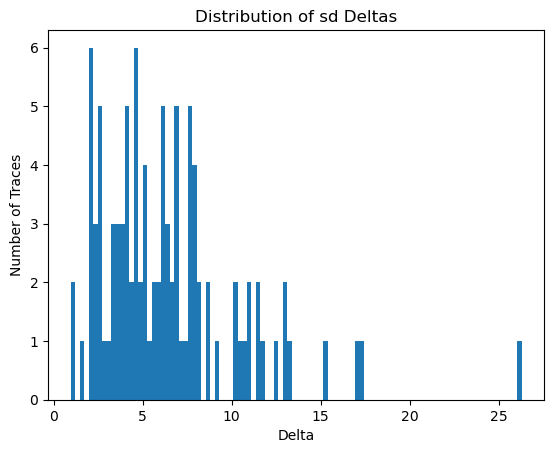

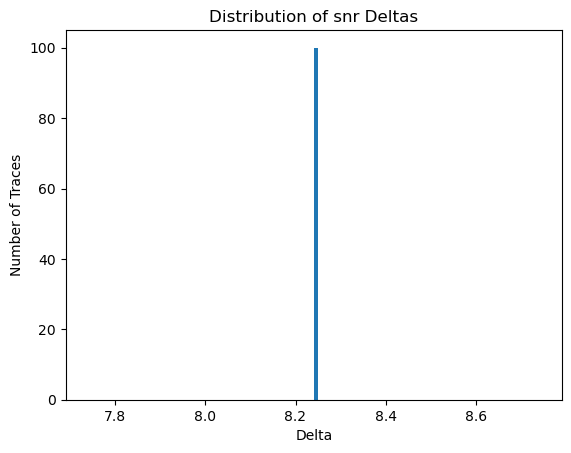

In [ ]:
# for traces_2 bulk tests, plot the number of traces for each delta between expected and measured values
import matplotlib.pyplot as plt


for measurement_type in ['max_amp', 'latency', 'max_amp_latency', 'half_width', 'sd', 'snr']:
    deltas = []
    for i, trace in enumerate(traces_2):
        tp = TraceProperties(trace, startPt, numPt, 0.5)
        if measurement_type == 'max_amp':
            measured_value = tp.get_max_amp()
            expected_value = max_amp_expected_2[i]
        elif measurement_type == 'latency':
            measured_value = tp.get_half_amp_latency()
            expected_value = latency_expected_2[i]
        elif measurement_type == 'max_amp_latency':
            measured_value = tp.get_max_amp_latency()
            expected_value = max_amp_latency_expected_2[i]
        elif measurement_type == 'half_width':
            measured_value = tp.get_half_width()
            expected_value = halfwidth_expected_2[i]
        elif measurement_type == 'sd':
            measured_value = tp.get_SD()
            expected_value = snr_expected_2[i]
        elif measurement_type == 'snr':
            measured_value = tp.get_SNR()
            expected_value = snr_expected_2[i]
        delta = np.abs((measured_value - expected_value) / measured_value)
        deltas.append(delta)
    plt.hist(deltas, bins=100)
    plt.xlabel('Delta')
    plt.ylabel('Number of Traces')
    plt.title(f'Distribution of {measurement_type} Deltas')
    plt.show()